In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sounddevice as sd
from scipy.signal import get_window, freqz, lfilter
from scipy.linalg import solve_toeplitz

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 1. Load the speech file speech1.wav

Loaded speech1.wav with sampling rate: 16000 Hz
Signal duration: 2.84 seconds
Signal shape: (45466,)


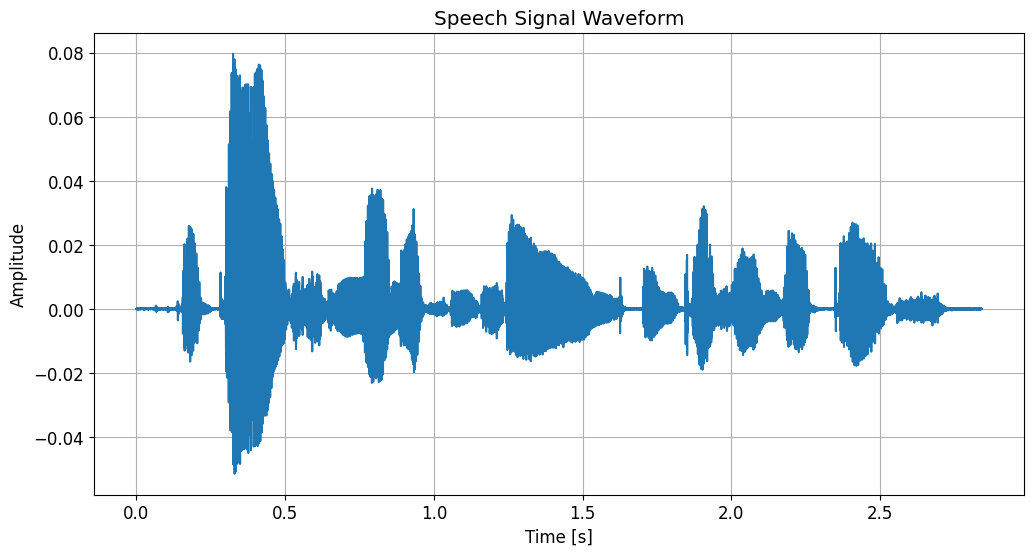

In [2]:
# Load the speech signal
speech, fs = librosa.load("speech1.wav", sr=None)

# Print basic information
print(f"Loaded speech1.wav with sampling rate: {fs} Hz")
print(f"Signal duration: {len(speech)/fs:.2f} seconds")
print(f"Signal shape: {speech.shape}")

# Create time vector for plotting
time = np.arange(len(speech)) / fs

# Plot the waveform
plt.figure()
plt.plot(time, speech)
plt.title('Speech Signal Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## 2. Select one unvoiced and one voiced speech segment

We'll select one unvoiced and one voiced segment from the speech signal, each with a length of 32 ms, and apply a Hann window.

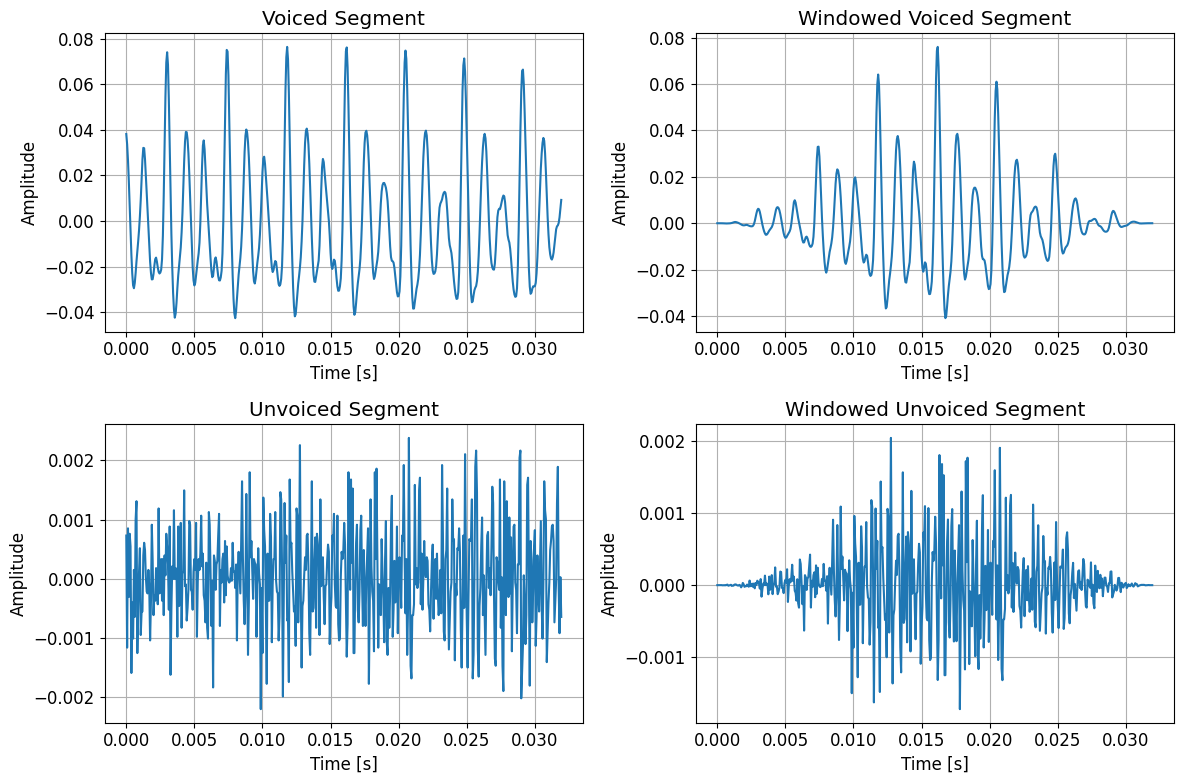

In [3]:
# Function to convert milliseconds to samples
def ms_to_samples(ms, fs):
    return int(ms * fs / 1000)

# Define segment length in ms and samples
segment_length_ms = 32
segment_length_samples = ms_to_samples(segment_length_ms, fs)

# Based on previous analysis, select voiced and unvoiced segments
# Voiced segment around 0.4-0.45s (similar to Exercise 1)
voiced_start = int(0.40 * fs)
voiced_end = voiced_start + segment_length_samples
voiced_segment = speech[voiced_start:voiced_end]

# Unvoiced segment around 1.0-1.05s (fricative sound)
unvoiced_start = int(1.0 * fs)
unvoiced_end = unvoiced_start + segment_length_samples
unvoiced_segment = speech[unvoiced_start:unvoiced_end]

# Create time vectors for the segments
voiced_time = np.arange(len(voiced_segment)) / fs
unvoiced_time = np.arange(len(unvoiced_segment)) / fs

# Create Hann window
window = get_window('hann', segment_length_samples)

# Apply window to both segments
voiced_windowed = voiced_segment * window
unvoiced_windowed = unvoiced_segment * window

# Plot both segments
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(voiced_time, voiced_segment)
plt.title('Voiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(voiced_time, voiced_windowed)
plt.title('Windowed Voiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(unvoiced_time, unvoiced_segment)
plt.title('Unvoiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(unvoiced_time, unvoiced_windowed)
plt.title('Windowed Unvoiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

✅ Answer:

The voiced segment shows clear periodicity with regular oscillations, indicating vocal fold vibration. The unvoiced segment has a more noise-like appearance without clear periodicity, typical of fricative sounds where air passes through a constriction without vocal fold vibration.

In [4]:
# Play the segments to verify
print("Playing voiced segment:")
sd.play(voiced_segment, fs)
sd.wait()


Playing voiced segment:


In [5]:
print("Playing unvoiced segment:")
sd.play(unvoiced_segment, fs)
sd.wait()

Playing unvoiced segment:


## 3. Compute the M=12-order LP coefficients

We'll compute the linear prediction coefficients by solving equation 4 from the exercise description using the autocorrelation method.

In [6]:
def compute_lp_coefficients(signal, order):
    """
    Compute Linear Prediction coefficients using autocorrelation method.
    
    Parameters:
        signal: Input signal segment
        order: Order of the LP filter (M)
        
    Returns:
        a: LP coefficients
    """
    # Compute autocorrelation
    # We need autocorrelation values from 0 to M
    r = np.correlate(signal, signal, mode='full')
    # Extract the positive lags (center to right half)
    r = r[len(signal)-1:len(signal)+order+1]
    
    # Create the Toeplitz matrix (R_s in the exercise)
    # First row is r[0] to r[order-1]
    # We need to solve -R_s * a = phi_s, where phi_s is r[1:order+1]
    # solve_toeplitz expects the first row and first column
    # Since R_s is symmetric, first row = first column
    a = solve_toeplitz(r[:order], r[1:order+1])
    
    # Return the LP coefficients
    return a

# Set the LP order
lp_order = 12

# Compute LP coefficients for both segments
a_voiced = compute_lp_coefficients(voiced_windowed, lp_order)
a_unvoiced = compute_lp_coefficients(unvoiced_windowed, lp_order)

# Print the coefficients
print("LP coefficients for voiced segment:")
print(a_voiced)
print("\nLP coefficients for unvoiced segment:")
print(a_unvoiced)

LP coefficients for voiced segment:
[ 3.06998779 -3.47369564  0.57966156  2.64783099 -2.56433745 -0.37774584
  2.57795921 -2.08766716  0.26426979  0.67338287 -0.4287071   0.05052545]

LP coefficients for unvoiced segment:
[ 0.04217562 -0.32858562 -0.19504786 -0.14724803 -0.1180281  -0.00436231
 -0.04883227  0.04022302 -0.11093861  0.03158485 -0.06339895  0.00334665]


Voiced: 
Coefficients are much larger in magnitude (several are >2 or 3).
large, structured taps → sharp vocal‐tract resonances → clear formant peaks in the spectrum

Unvoiced: 
Coefficents are small (well below 1), with no strong alternating pattern.
small, “random” taps → only slight shaping of flat noise → a smoother, flatter spectral envelope.


✅ Answer:

The LP coefficients represent the filter that models the vocal tract. For the voiced segment, these coefficients capture the resonances (formants) of the vocal tract during vowel production. For the unvoiced segment, they model the spectral shape of the noise-like sound produced by turbulent airflow.



## 4. Plot the frequency response of the estimated vocal tract filter H(z)

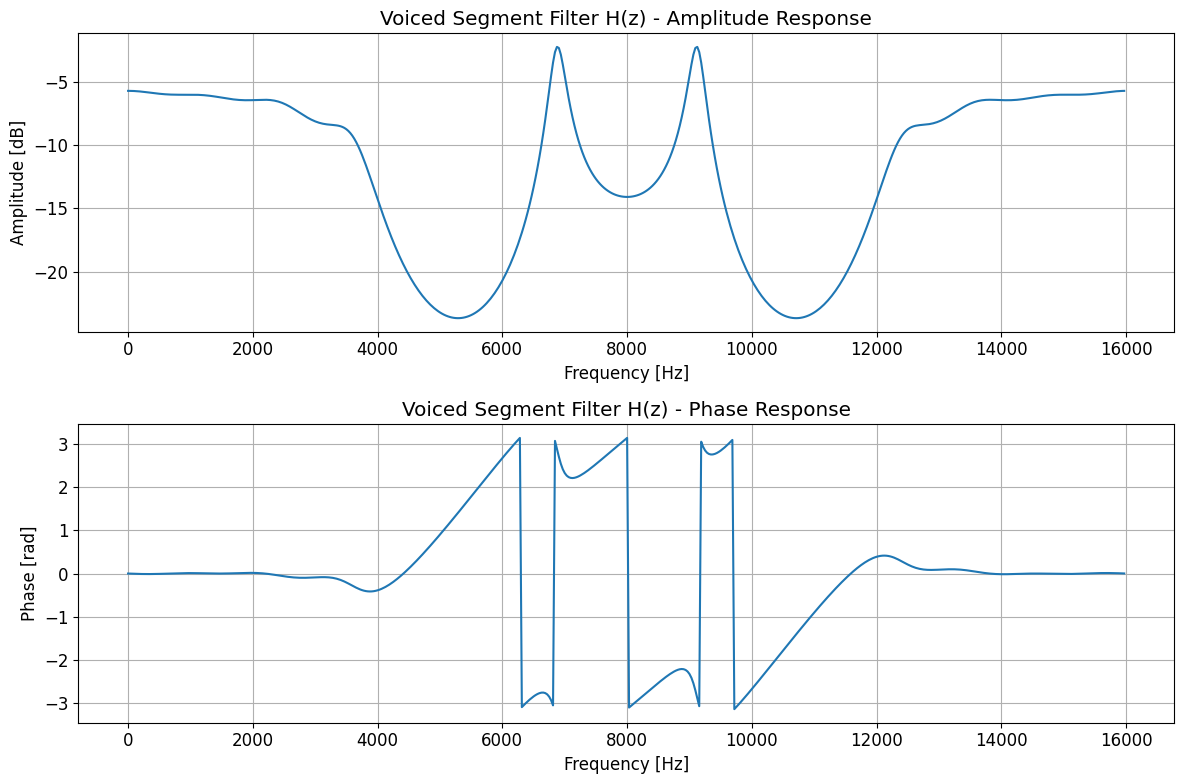

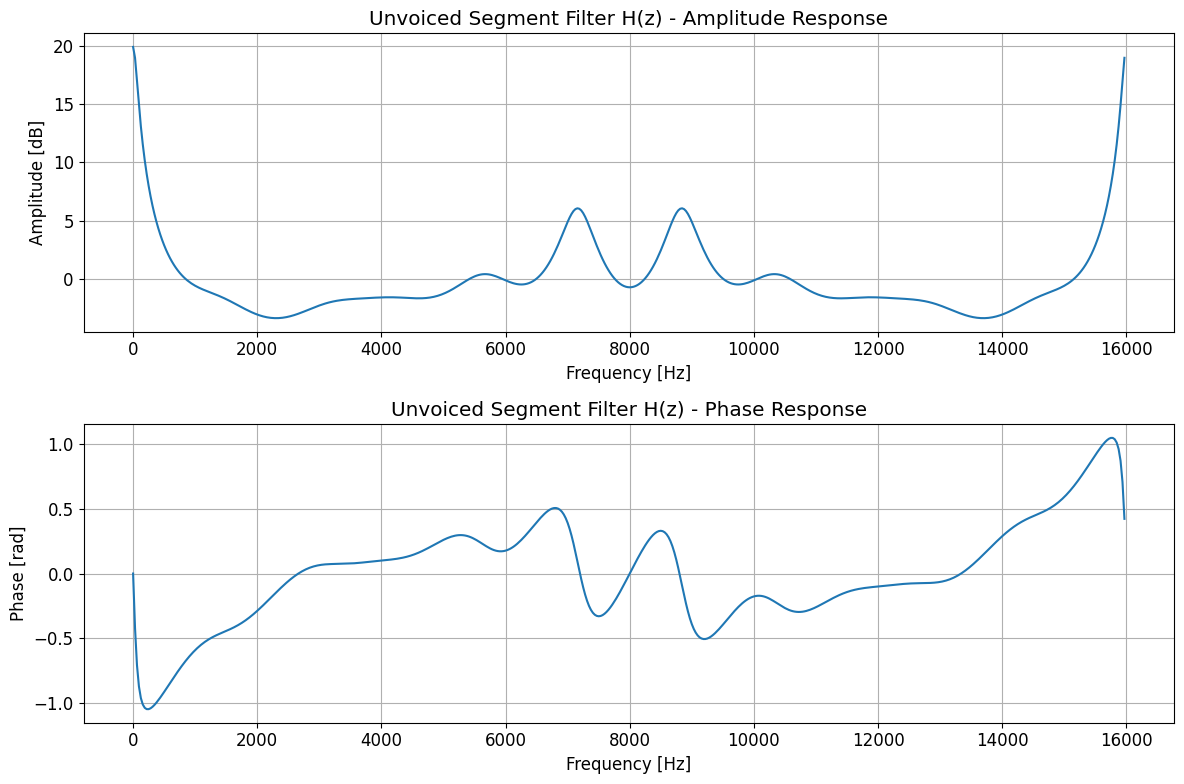

In [7]:
def plot_filter_response(a, fs, num_points, title):
    """
    Plot the frequency response (amplitude and phase) of the filter H(z).
    
    Parameters:
        a: LP coefficients
        fs: Sampling frequency
        num_points: Number of frequency points
        title: Plot title
    """
    # Compute the frequency response
    # H(z) = 1 / (1 + sum(a_i * z^-i))
    # For freqz, we need numerator=[1] and denominator=[1, a_1, a_2, ..., a_M]
    w, h = freqz(1, np.concatenate(([1], a)), num_points, whole=True, fs=fs)
    
    # Plot amplitude and phase
    plt.figure(figsize=(12, 8))
    
    # Amplitude response in dB
    plt.subplot(2, 1, 1)
    plt.plot(w, 20 * np.log10(np.abs(h)))
    plt.title(f'{title} - Amplitude Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(True)
    
    # Phase response
    plt.subplot(2, 1, 2)
    plt.plot(w, np.angle(h))
    plt.title(f'{title} - Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [rad]')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the frequency response for both segments
plot_filter_response(a_voiced, fs, segment_length_samples, 'Voiced Segment Filter H(z)')
plot_filter_response(a_unvoiced, fs, segment_length_samples, 'Unvoiced Segment Filter H(z)')

Voiced‐segment filter H(z)
-Formant peaks: In a voiced segment (e.g. a vowel), the excitation is an impulse train at the pitch frequency.
-Spectral valleys: Between formants the gain drops off. Because this is an all-pole filter there are no true “notches” (zeros), but the envelope still shows valleys in between the resonance peaks.
-Overall level: The DC gain (at 0 Hz) comes out around –5 dB here because H(0)=1/A(1)=1/(1+∑aᵢ) and ∑aᵢ turned out to be slightly positive for this segment.


Unvoiced‐segment filter H(z)
-Broadband shape: An unvoiced segment (a fricative or noise burst) has a noise excitation, which is spectrally flat. The LPC filter therefore learns to impose the average spectral envelope of that noisy segment.
-Milder resonances: There are only a few gentle bumps where the tract happened to amplify the noise a bit (for instance around 7–8 kHz if it was an “s” sound). You do not see the sharp formant peaks of a vowel.
-Spectral tilt / boosts: You also note a slight low-frequency lift and even a high-frequency rise right near Nyquist—this simply matches whatever low/high-band energy was present in the noise segment you picked.

Phase response: Because none of the poles sit very close to the unit circle here, the phase is even smoother than in the voiced case and never develops the steep kinks or wraps. It’s still minimum-phase, but with a more evenly distributed pole set the phase slope is gentle everywhere.




### 4b) Why do you use np.concatenate(([1], a)) and not only a?

✅ Answer:

We use `np.concatenate(([1], a))` because the denominator of the filter H(z) is defined as:

H(z) = 1 / (1 + sum(a_i * z^-i))

The denominator polynomial is 1 + a_1*z^-1 + a_2*z^-2 + ... + a_M*z^-M, which corresponds to the coefficient array [1, a_1, a_2, ..., a_M]. The `freqz` function expects the complete polynomial coefficients, so we need to prepend 1 to the LP coefficients array to represent this denominator correctly.

## 5. Compare DFT of windowed segments with filter frequency response

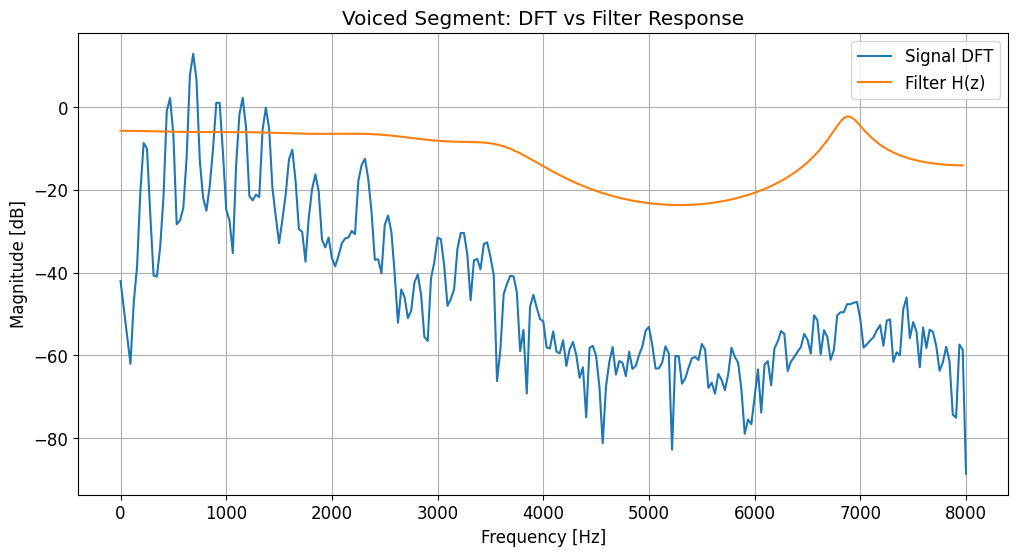

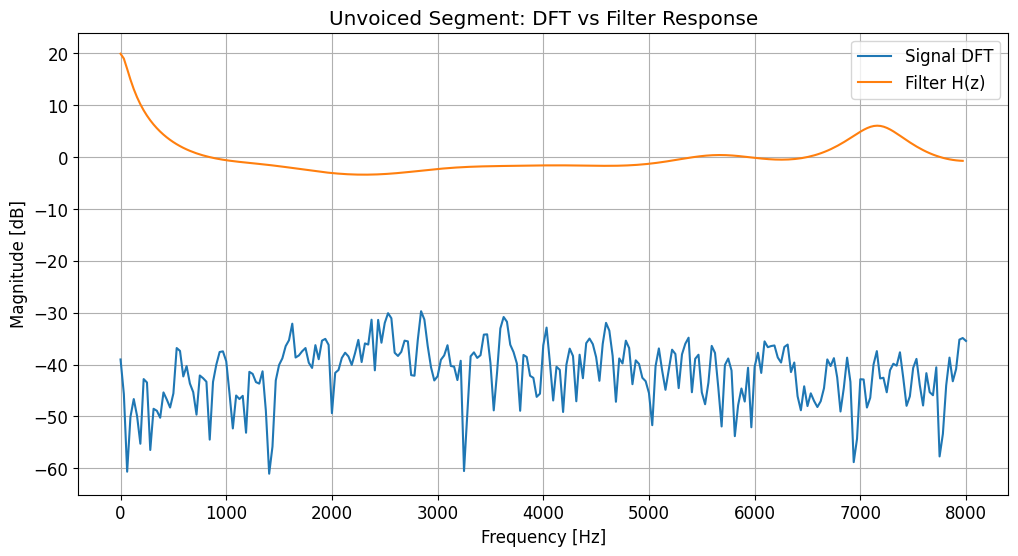

In [8]:
def plot_spectrum_and_filter(segment, a, fs, title):
    """
    Plot the DFT magnitude of the segment and the filter frequency response.
    
    Parameters:
        segment: Input signal segment
        a: LP coefficients
        fs: Sampling frequency
        title: Plot title
    """
    # Compute DFT of the segment
    S = np.fft.rfft(segment)
    # Frequency axis for the DFT
    freq_dft = np.fft.rfftfreq(len(segment), 1/fs)
    
    # Compute filter frequency response at the same frequency points
    w, h = freqz(1, np.concatenate(([1], a)), len(freq_dft), whole=False, fs=fs)
    
    # Plot both on the same figure
    plt.figure()
    plt.plot(freq_dft, 20 * np.log10(np.abs(S)), label='Signal DFT')
    plt.plot(w, 20 * np.log10(np.abs(h)), label='Filter H(z)')
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for both segments
plot_spectrum_and_filter(voiced_windowed, a_voiced, fs, 'Voiced Segment: DFT vs Filter Response')
plot_spectrum_and_filter(unvoiced_windowed, a_unvoiced, fs, 'Unvoiced Segment: DFT vs Filter Response')

✅ Answer:

The plots show the DFT magnitude of the windowed segments compared to the frequency response of the estimated vocal tract filter H(z). For the voiced segment, we can see clear peaks in both the DFT and filter response, corresponding to the formants (resonances of the vocal tract). The filter response provides a smoothed envelope of the DFT, capturing the spectral shape while ignoring the harmonic structure. For the unvoiced segment, both curves show a broader spectral distribution typical of noise-like sounds.

## 6. Compute and analyze the residual signal

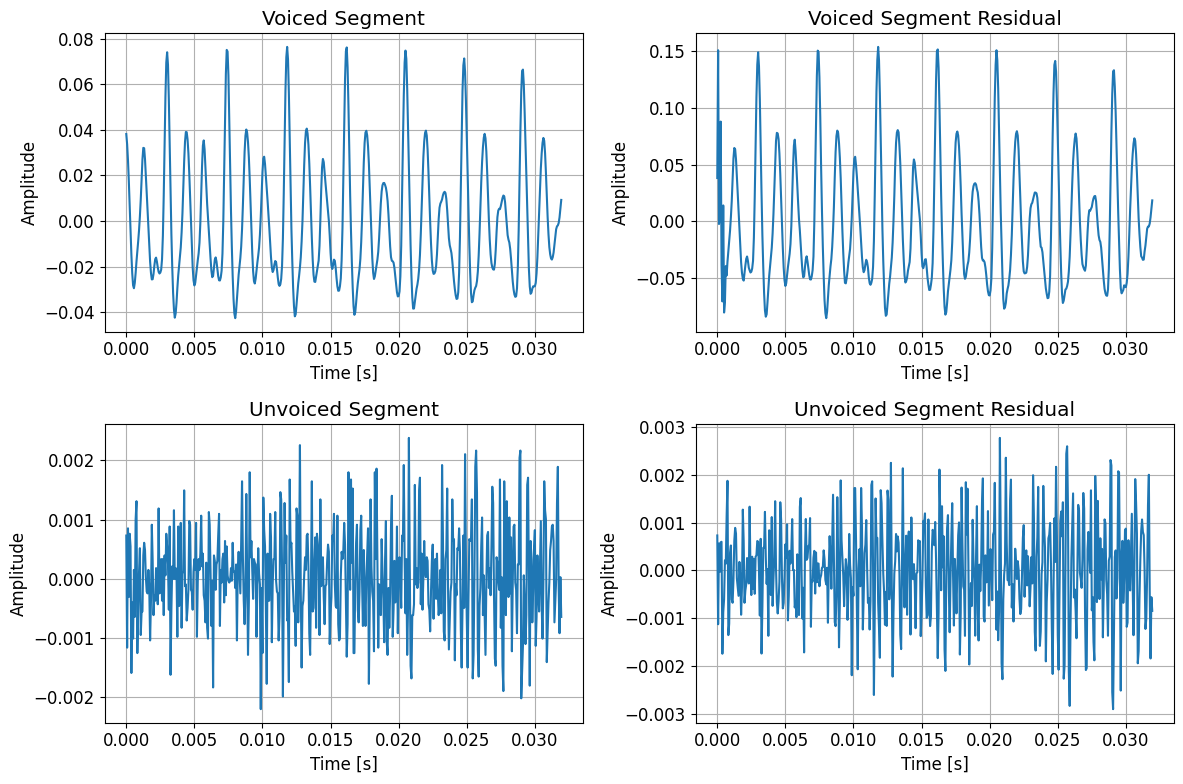

In [9]:
# Compute residual signals using inverse filtering
e_voiced = lfilter(np.concatenate(([1], a_voiced)), 1, voiced_segment)
e_unvoiced = lfilter(np.concatenate(([1], a_unvoiced)), 1, unvoiced_segment)

# Plot original segments and their residuals
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(voiced_time, voiced_segment)
plt.title('Voiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(voiced_time, e_voiced)
plt.title('Voiced Segment Residual')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(unvoiced_time, unvoiced_segment)
plt.title('Unvoiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(unvoiced_time, e_unvoiced)
plt.title('Unvoiced Segment Residual')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

### 6b) Explain differences in e between the voiced and unvoiced segment.

✅ Answer:

The residual signals show clear differences between voiced and unvoiced segments:

1. **Voiced residual**: Shows a quasi-periodic impulse-like structure with clear peaks at regular intervals. These peaks correspond to the glottal pulses (moments when the vocal folds open). The LP analysis has effectively removed the vocal tract resonances, leaving primarily the excitation signal which is pulse-like for voiced speech.

2. **Unvoiced residual**: Appears more noise-like and random, without clear periodicity. This is expected since unvoiced speech is produced with turbulent airflow (noise-like excitation) rather than vocal fold vibration. The residual maintains this noise-like character but with a flatter spectrum since the spectral shaping of the vocal tract has been removed.

These differences align with the source-filter model of speech production, where voiced sounds have a pulse train excitation and unvoiced sounds have a noise excitation.

### 6c) Explain why scipy.signal.lfilter(np.concatenate(([1], a)), 1, s) yields the residual signal.

✅ Answer:

The function `scipy.signal.lfilter(np.concatenate(([1], a)), 1, s)` performs inverse filtering to obtain the residual signal because:

1. According to the source-filter model, the speech signal s(n) is produced by filtering the excitation signal e(n) with the vocal tract filter H(z): S(z) = H(z) · E(z)

2. The vocal tract filter is modeled as H(z) = 1 / (1 + sum(a_i * z^-i))

3. To recover the excitation/residual signal, we need to apply the inverse of H(z): E(z) = S(z) / H(z) = S(z) · (1 + sum(a_i * z^-i))

4. In the time domain, this corresponds to filtering s(n) with the filter 1 + sum(a_i * z^-i), which is represented by the coefficients [1, a_1, a_2, ..., a_M]

5. The `lfilter` function applies a filter with the given numerator and denominator coefficients. By setting the numerator to [1, a_1, a_2, ..., a_M] and the denominator to 1, we're implementing the inverse filter that yields the residual signal.

## 7. Analyze and modify the filter to match the signal spectrum

### 7a) Why are the logarithmic amplitudes of H and S not on the same level?

✅ Answer:

The logarithmic amplitudes of H and S are not on the same level because:

1. The filter H(z) represents only the spectral shape (vocal tract filter) and doesn't account for the energy/gain of the excitation signal.

2. In the source-filter model, the complete model is S(z) = g·E(z)·H(z), where g is a gain factor representing the energy of the excitation.

3. When we estimate H(z) through LP analysis, we only get the shape of the filter without this gain factor.

4. Therefore, there's a constant offset between the logarithmic amplitudes of H and S, which corresponds to the energy of the excitation signal.

### 7b) How can you modify H to achieve a better match?

✅ Answer:

To achieve a better match between H and S, we need to account for the energy of the excitation signal. We can modify H by scaling it with the energy of the residual signal:

1. Calculate the energy (power) of the residual signal: g² = mean(e²)
2. Scale the filter response by this energy: H_modified(z) = g·H(z)
3. In the logarithmic domain, this is equivalent to adding 10·log10(g²) to the dB values of H(z)

This scaling accounts for the excitation energy that was not captured in the original filter estimate.

Energy of voiced residual: 0.003132
Energy of unvoiced residual: 0.000001


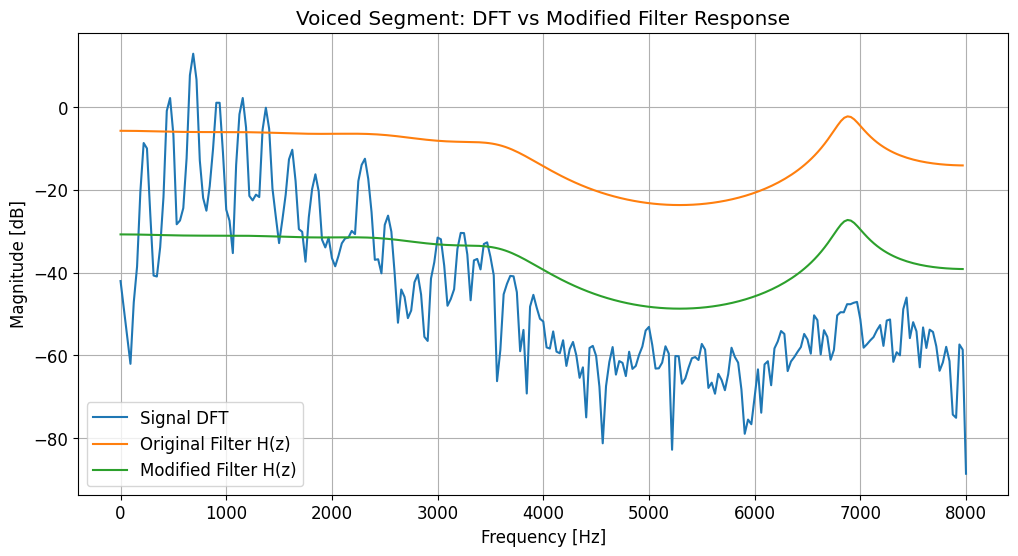

In [10]:
# Calculate the energy of the residual signals
energy_voiced = np.mean(e_voiced**2)
energy_unvoiced = np.mean(e_unvoiced**2)

print(f"Energy of voiced residual: {energy_voiced:.6f}")
print(f"Energy of unvoiced residual: {energy_unvoiced:.6f}")

# Function to plot modified filter response
def plot_modified_spectrum_and_filter(segment, a, residual_energy, fs, title):
    """
    Plot the DFT magnitude of the segment and the modified filter frequency response.
    
    Parameters:
        segment: Input signal segment
        a: LP coefficients
        residual_energy: Energy of the residual signal
        fs: Sampling frequency
        title: Plot title
    """
    # Compute DFT of the segment
    S = np.fft.rfft(segment)
    # Frequency axis for the DFT
    freq_dft = np.fft.rfftfreq(len(segment), 1/fs)
    
    # Compute filter frequency response at the same frequency points
    w, h = freqz(1, np.concatenate(([1], a)), len(freq_dft), whole=False, fs=fs)
    
    # Modify the filter response by scaling with residual energy
    h_modified = h * np.sqrt(residual_energy)
    
    # Plot both on the same figure
    plt.figure()
    plt.plot(freq_dft, 20 * np.log10(np.abs(S)), label='Signal DFT')
    plt.plot(w, 20 * np.log10(np.abs(h)), label='Original Filter H(z)')
    plt.plot(w, 20 * np.log10(np.abs(h_modified)), label='Modified Filter H(z)')
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for the voiced segment
plot_modified_spectrum_and_filter(voiced_windowed, a_voiced, energy_voiced, fs, 
                                 'Voiced Segment: DFT vs Modified Filter Response')

✅ Answer:

The modified filter response now better matches the overall level of the signal's DFT. The scaling by the residual energy accounts for the excitation strength that was missing in the original filter estimate. The filter still provides a smoothed envelope of the spectrum, capturing the formant structure while ignoring the harmonic details.

## 8. Experiment with different LP orders

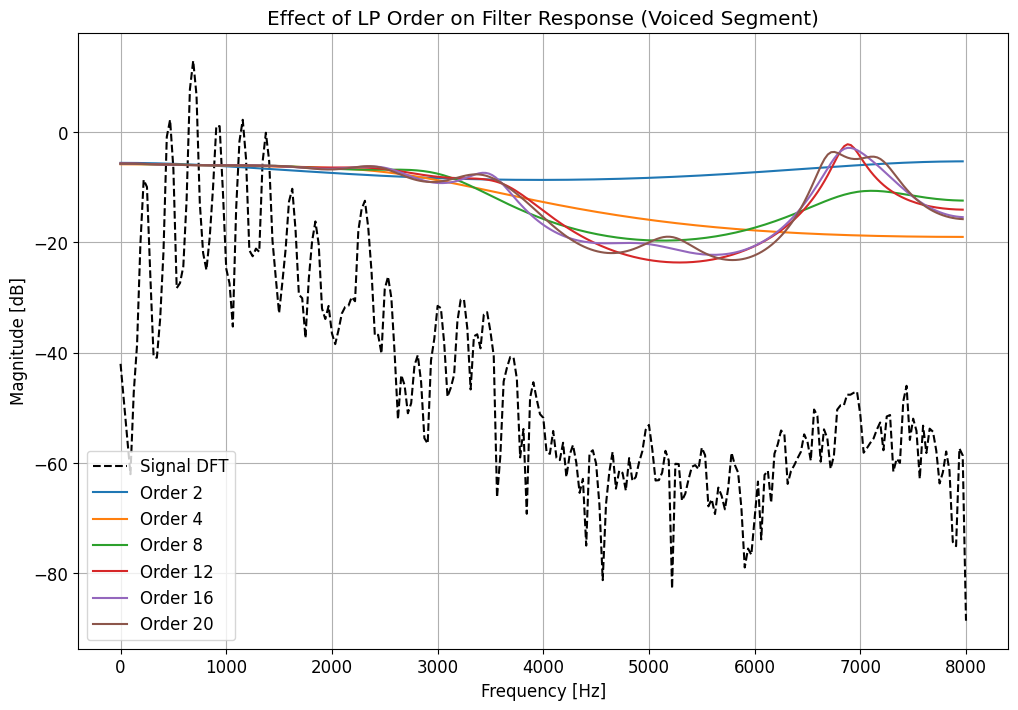

In [11]:
# Test different LP orders
orders = [2, 4, 8, 12, 16, 20]

plt.figure(figsize=(12, 8))

# Compute DFT of the voiced segment for reference
S_voiced = np.fft.rfft(voiced_windowed)
freq_dft = np.fft.rfftfreq(len(voiced_windowed), 1/fs)

# Plot DFT as reference
plt.plot(freq_dft, 20 * np.log10(np.abs(S_voiced)), 'k--', label='Signal DFT')

# Compute and plot filter responses for different orders
for order in orders:
    # Compute LP coefficients
    a = compute_lp_coefficients(voiced_windowed, order)
    
    # Compute filter frequency response
    w, h = freqz(1, np.concatenate(([1], a)), len(freq_dft), whole=False, fs=fs)
    
    # Plot
    plt.plot(w, 20 * np.log10(np.abs(h)), label=f'Order {order}')

plt.title('Effect of LP Order on Filter Response (Voiced Segment)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

✅ Answer:

The LP order significantly affects the filter response H(z):

1. **Low orders (2-4)**: Capture only the gross spectral shape with 1-2 major peaks. These can model the overall spectral tilt but miss most formants.

2. **Medium orders (8-12)**: Provide a good balance, capturing the main formant structure (typically 3-5 formants) while still providing some smoothing. This is often sufficient for speech analysis and synthesis.

3. **High orders (16-20)**: Capture finer spectral details, potentially including harmonics in voiced speech. While this provides a closer match to the original spectrum, it may overfit to noise or specific characteristics of the analyzed frame.

The optimal order depends on the application. For speech coding and synthesis, orders around 10-14 are common as they capture the vocal tract resonances without modeling the harmonic structure (which should come from the excitation).

## 9. Pre-emphasis filter

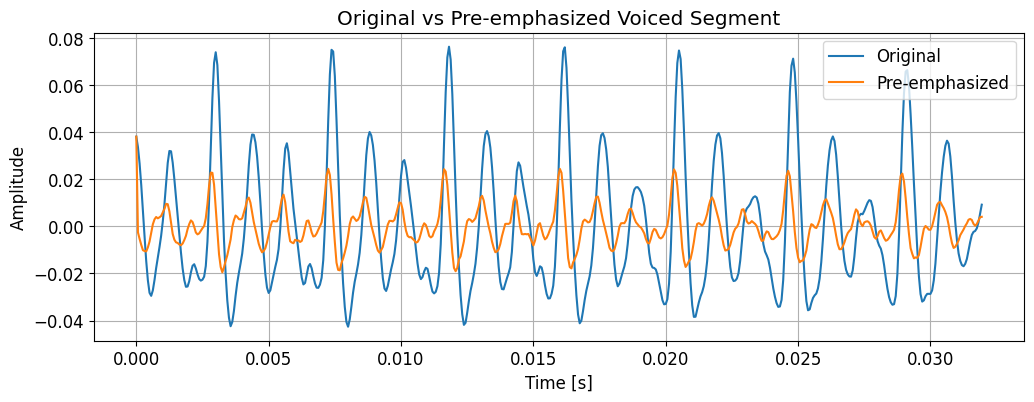

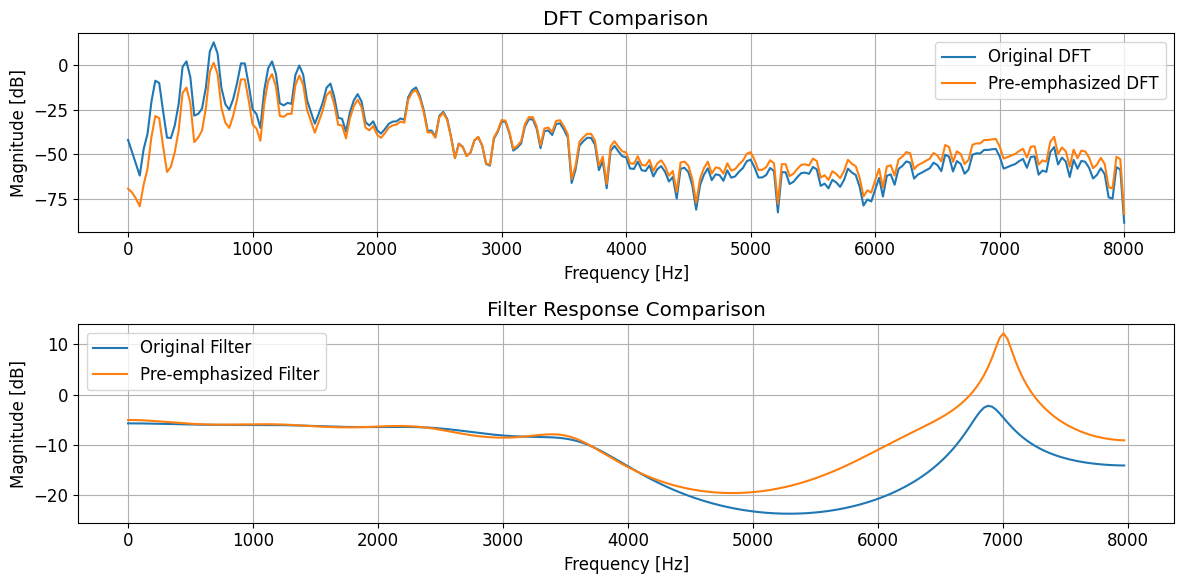

In [12]:
# Apply pre-emphasis filter to the voiced segment
alpha = 0.95
voiced_preemph = lfilter([1, -alpha], 1, voiced_segment)

# Plot original and pre-emphasized signals
plt.figure(figsize=(12, 4))
plt.plot(voiced_time, voiced_segment, label='Original')
plt.plot(voiced_time, voiced_preemph, label='Pre-emphasized')
plt.title('Original vs Pre-emphasized Voiced Segment')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Apply window to pre-emphasized signal
voiced_preemph_windowed = voiced_preemph * window

# Compute LP coefficients for both original and pre-emphasized signals
a_voiced_orig = compute_lp_coefficients(voiced_windowed, lp_order)
a_voiced_preemph = compute_lp_coefficients(voiced_preemph_windowed, lp_order)

# Compare filter responses
plt.figure(figsize=(12, 6))

# Compute DFT of both signals
S_orig = np.fft.rfft(voiced_windowed)
S_preemph = np.fft.rfft(voiced_preemph_windowed)
freq_dft = np.fft.rfftfreq(len(voiced_windowed), 1/fs)

# Plot DFTs
plt.subplot(2, 1, 1)
plt.plot(freq_dft, 20 * np.log10(np.abs(S_orig)), label='Original DFT')
plt.plot(freq_dft, 20 * np.log10(np.abs(S_preemph)), label='Pre-emphasized DFT')
plt.title('DFT Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)

# Compute and plot filter responses
w, h_orig = freqz(1, np.concatenate(([1], a_voiced_orig)), len(freq_dft), whole=False, fs=fs)
_, h_preemph = freqz(1, np.concatenate(([1], a_voiced_preemph)), len(freq_dft), whole=False, fs=fs)

plt.subplot(2, 1, 2)
plt.plot(w, 20 * np.log10(np.abs(h_orig)), label='Original Filter')
plt.plot(w, 20 * np.log10(np.abs(h_preemph)), label='Pre-emphasized Filter')
plt.title('Filter Response Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 9a) Compare the results with and without pre-emphasis

✅ Answer:

Comparing the LP analysis with and without pre-emphasis shows several key differences:

1. **Spectral tilt**: The pre-emphasized signal shows a flatter spectrum compared to the original signal, which has a natural spectral tilt of approximately -6 dB/octave. This is visible in both the DFT and the filter response.

2. **Formant visibility**: In the pre-emphasized signal, higher frequency formants are more prominent and easier to identify. The pre-emphasis filter boosts the higher frequencies, making them more significant in the LP analysis.

3. **Filter response**: The LP filter estimated from the pre-emphasized signal shows more distinct and well-defined formant peaks, especially in the higher frequency regions. This is because the pre-emphasis reduces the dynamic range between low and high frequencies, allowing the LP analysis to model all formants more equally.

4. **LP coefficients**: The coefficients themselves differ, with the pre-emphasized signal's coefficients giving more weight to higher frequency components.

### 9b) What is the advantage of pre-emphasizing the speech signal?

✅ Answer:

Pre-emphasizing speech signals before LP analysis offers several advantages:

1. **Spectral flattening**: Speech naturally has a spectral tilt of approximately -6 dB/octave due to the glottal source and radiation characteristics. Pre-emphasis counteracts this tilt, creating a more balanced spectrum where all frequencies have similar importance.

2. **Improved formant estimation**: By boosting higher frequencies, pre-emphasis makes higher formants (F2, F3, etc.) more prominent, allowing the LP analysis to model them more accurately. Without pre-emphasis, the LP model might focus primarily on the dominant lower frequencies.

3. **Reduced dynamic range**: Pre-emphasis reduces the dynamic range between low and high frequencies, which helps prevent numerical issues in the LP analysis and improves the condition number of the autocorrelation matrix.

4. **Better perceptual quality**: In speech coding applications, pre-emphasis helps preserve perceptually important high-frequency components that might otherwise be lost or poorly modeled.

5. **Noise reduction**: Pre-emphasis can also help reduce the effect of low-frequency noise, which is often more prominent in speech recordings.

These advantages make pre-emphasis a standard preprocessing step in many speech processing applications, particularly those involving linear prediction analysis.